### Modèle de segmentation Unet pour détection contour cellule

In [1]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import cv2

##### Base de contour réalisé par détection contour OpenCV

In [2]:
df = pd.read_csv('../files_segmentation.csv', index_col=0)

In [3]:
input_img_paths = df['file_path']

In [4]:
target_img_paths = df['filename'].apply(lambda file: '../images_segmentation/trimaps/'+ file.split('.')[0]+'.png')

In [5]:
img_size = (160, 160)
num_classes = 3
batch_size = 32

In [6]:
class Cells(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            #y[j] -= 1
        return x, y

#### Définition d'un modèle UNET

In [7]:
def get_modelUnet(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_modelUnet(img_size, num_classes)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 80, 80, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 80, 80, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [8]:
import random

# Split our img paths into a training and a validation set
val_samples = 400
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = Cells(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = Cells(batch_size, img_size, val_input_img_paths, val_target_img_paths)

C:\Users\LAURE\anaconda3\envs\Projet\lib\random.py:307: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[i], x[j] = x[j], x[i]


In [9]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

# Train the model, doing validation at the end of each epoch.
model.fit(train_gen, epochs=16, validation_data=val_gen)

Epoch 1/16
31/31 [==============================] - 251s 8s/step - loss: 0.7264 - val_loss: 7.1570
Epoch 2/16
31/31 [==============================] - 243s 8s/step - loss: 0.1406 - val_loss: 1.0387
Epoch 3/16
31/31 [==============================] - 220s 7s/step - loss: 0.1276 - val_loss: 0.4980
Epoch 4/16
31/31 [==============================] - 220s 7s/step - loss: 0.0870 - val_loss: 0.5825
Epoch 5/16
31/31 [==============================] - 235s 8s/step - loss: 0.0712 - val_loss: 0.8209
Epoch 6/16
31/31 [==============================] - 235s 8s/step - loss: 0.0657 - val_loss: 0.9349
Epoch 7/16
31/31 [==============================] - 217s 7s/step - loss: 0.0553 - val_loss: 1.1306
Epoch 8/16
31/31 [==============================] - 233s 8s/step - loss: 0.0528 - val_loss: 0.9103
Epoch 9/16
31/31 [==============================] - 217s 7s/step - loss: 0.0437 - val_loss: 1.1684
Epoch 10/16
31/31 [==============================] - 218s 7s/step - loss: 0.0408 - val_loss: 1.4205
Epoch 11/

In [96]:
model.save('segmentation_unet')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: segmentation_unet\assets


#### Visualisation des prédictions

In [11]:
def display(display_list):
    plt.figure(figsize=(10, 10))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        if i == 0:
            plt.imshow(display_list[i])
        else:
            plt.imshow(np.squeeze(display_list[i],-1), cmap = "gray")
        plt.axis('off')
    plt.show()

In [44]:
# Création du mask
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask

In [67]:
val_gen = Cells(32, img_size, val_input_img_paths, val_target_img_paths)

In [72]:
def show_predictions_dataset(dataset,  model):
    for image, mask in dataset:
        pred_mask = model.predict(image)
        display([image[2].astype(int), mask[2], create_mask(pred_mask[2])])

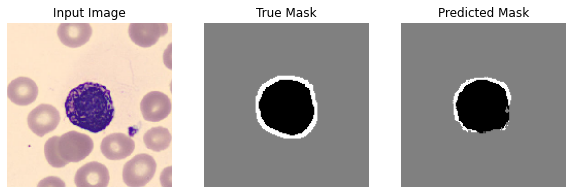

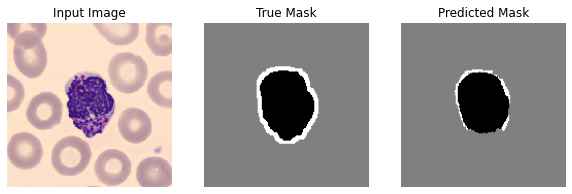

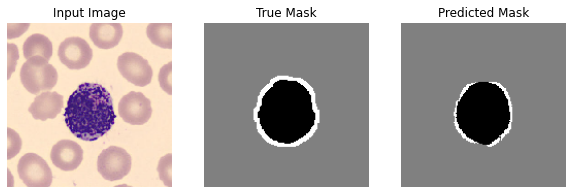

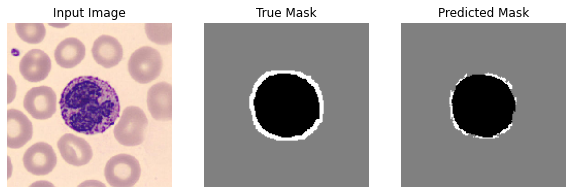

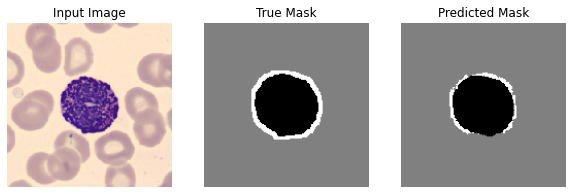

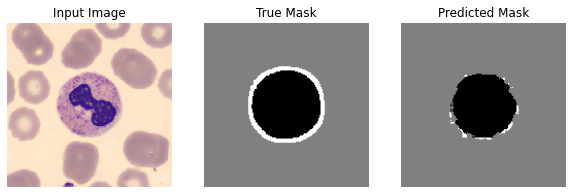

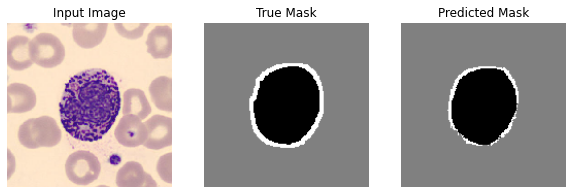

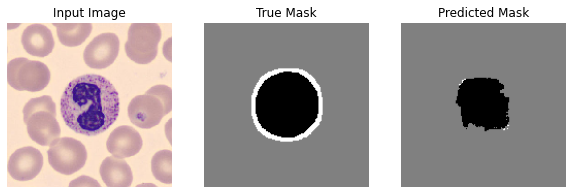

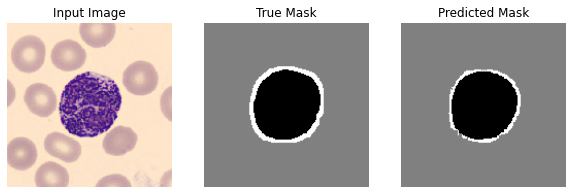

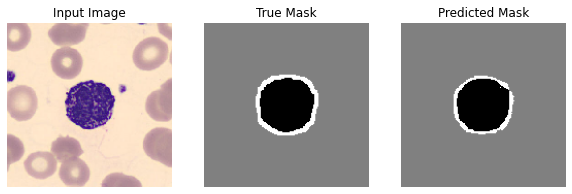

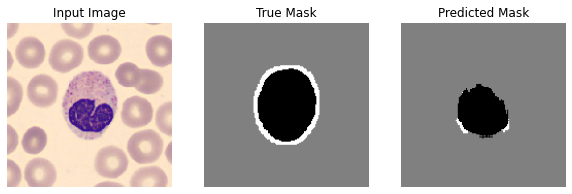

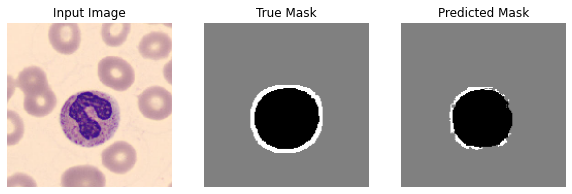

In [73]:
show_predictions_dataset(val_gen, model)

> Moins bon résultat qu'avec le modèle FNC mais entrainement plus rapide

In [91]:
# Prédictions image hors dataset
def load_and_preprocess_img(img_filepath):  
    img = tf.io.read_file(img_filepath)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, img_size)
    return img

In [92]:
def show_cells(list_path,  model):
    plt.figure(figsize=(20, 5))
    for i in range(len(list_path)):
        img_path = list_path[i]
        plt.subplot(1, len(list_path), i+1)
        img = load_and_preprocess_img(img_path)
        pred_mask = model.predict(tf.expand_dims(img, axis=0))
        img = cv2.imread(img_path, cv2.IMREAD_COLOR) 
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
        cell = img.copy()
        w = cell.shape[0]
        h = cell.shape[1]
        pred_mask = tf.image.resize(create_mask(pred_mask),(w, h)).numpy().reshape(w,h).astype('uint8')
        cell[ pred_mask !=0 ] = 0
        plt.imshow(cell)
        plt.axis('off')
    plt.show()

In [93]:
imgs = ['BA_18130766.jpg','BNE_596329.jpg','BA_426545.jpg','EO_780772.jpg'
           ]
data = pd.read_csv('../base_10_class.csv', index_col=0)

In [94]:
imgs_path = data[data['filename'].isin(imgs)]['file_path']

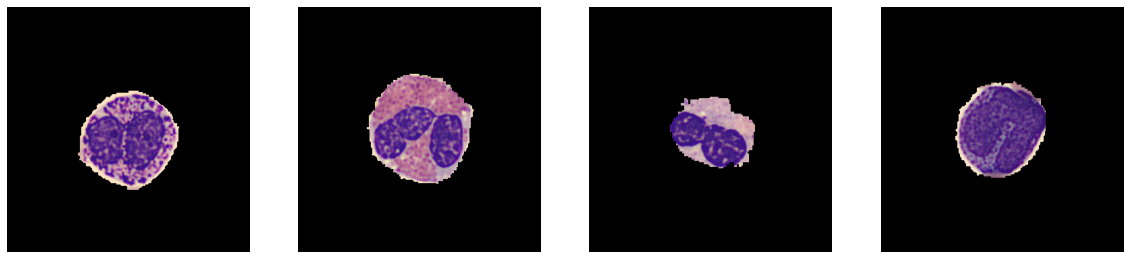

In [95]:
show_cells(imgs_path.values, model)

> Bon résultat de détourage de la cellule malgré les globules rouges agglomérés